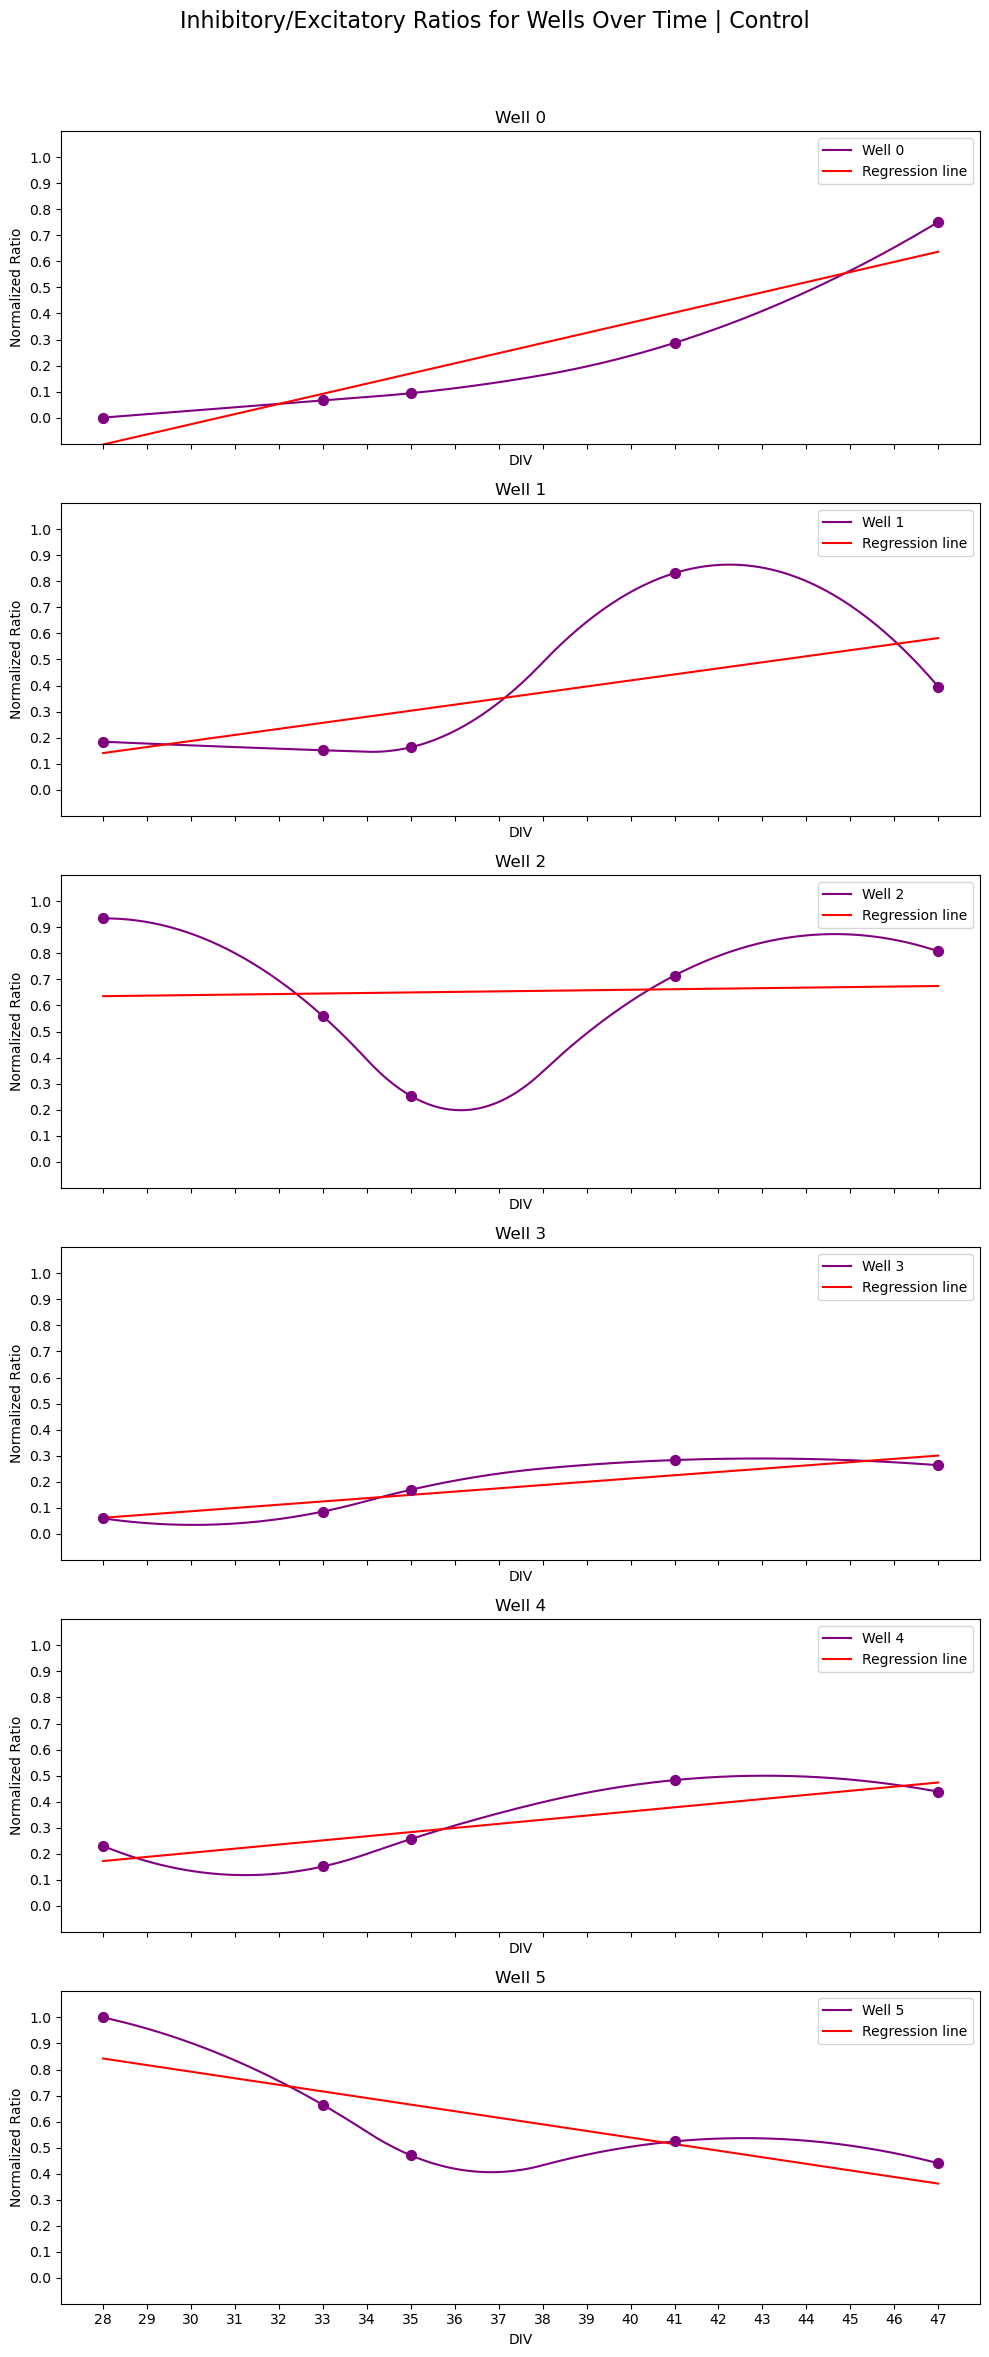

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.stats import linregress

#
#           ****** FOR CONTROL GROUP - CSV HEADER: Chip,DIV,Well,Inhibitory Count,Excitatory Count,Ratio
#

def plot_data1(file_path):

    df = pd.read_csv(file_path)

    df = df.sort_values(by=['DIV', 'Well'])

    unique_wells = df['Well'].unique()
    unique_times = df['DIV'].unique()

    fig, axes = plt.subplots(len(unique_wells), 1, figsize=(10, len(unique_wells) * 4), sharex=True)
    fig.suptitle(f'Inhibitory/Excitatory Ratios for Wells Over Time | Control', fontsize=16)

    # Normalize the Ratio values
    min_ratio = df['Ratio'].min()
    max_ratio = df['Ratio'].max()
    df['Normalized Ratio'] = (df['Ratio'] - min_ratio) / (max_ratio - min_ratio)

    for i, well in enumerate(unique_wells):
        ax = axes[i] if len(unique_wells) > 1 else axes
        group = df[df['Well'] == well]
        
        x_new = np.linspace(group['DIV'].min(), group['DIV'].max(), 300)
        spl = make_interp_spline(group['DIV'], group['Normalized Ratio'], k=2)
        y_smooth = spl(x_new)
        
        ax.plot(x_new, y_smooth, linestyle='-', label=f'Well {well}', color='purple')
        ax.scatter(group['DIV'], group['Normalized Ratio'], color='purple', s=50, zorder=5)
        
        # Add regression line
        slope, intercept, r_value, p_value, std_err = linregress(group['DIV'], group['Normalized Ratio'])
        ax.plot(group['DIV'], intercept + slope * group['DIV'], 'r', label='Regression line')
        
        ax.set_title(f'Well {well}')
        ax.set_xlabel('DIV')
        ax.set_ylabel('Normalized Ratio')
        buffer = 0.1  # 10% buffer
        ax.set_ylim(-buffer, 1 + buffer)  # Uniform y-axis limits with buffer
        ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the step size here
        ax.set_xticks(np.arange(group['DIV'].min(), group['DIV'].max() + 1, 1))
        ax.legend()
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.savefig(f'/Users/evankolberg/Desktop/HALnalysis_summer_2024_data/plots/M07480/ratios_1.png', dpi=800)
    plt.show()

file_path = '/Users/evankolberg/Desktop/HALnalysis_summer_2024_data/plots/M07480/chip_vis_data.csv'
plot_data1(file_path)

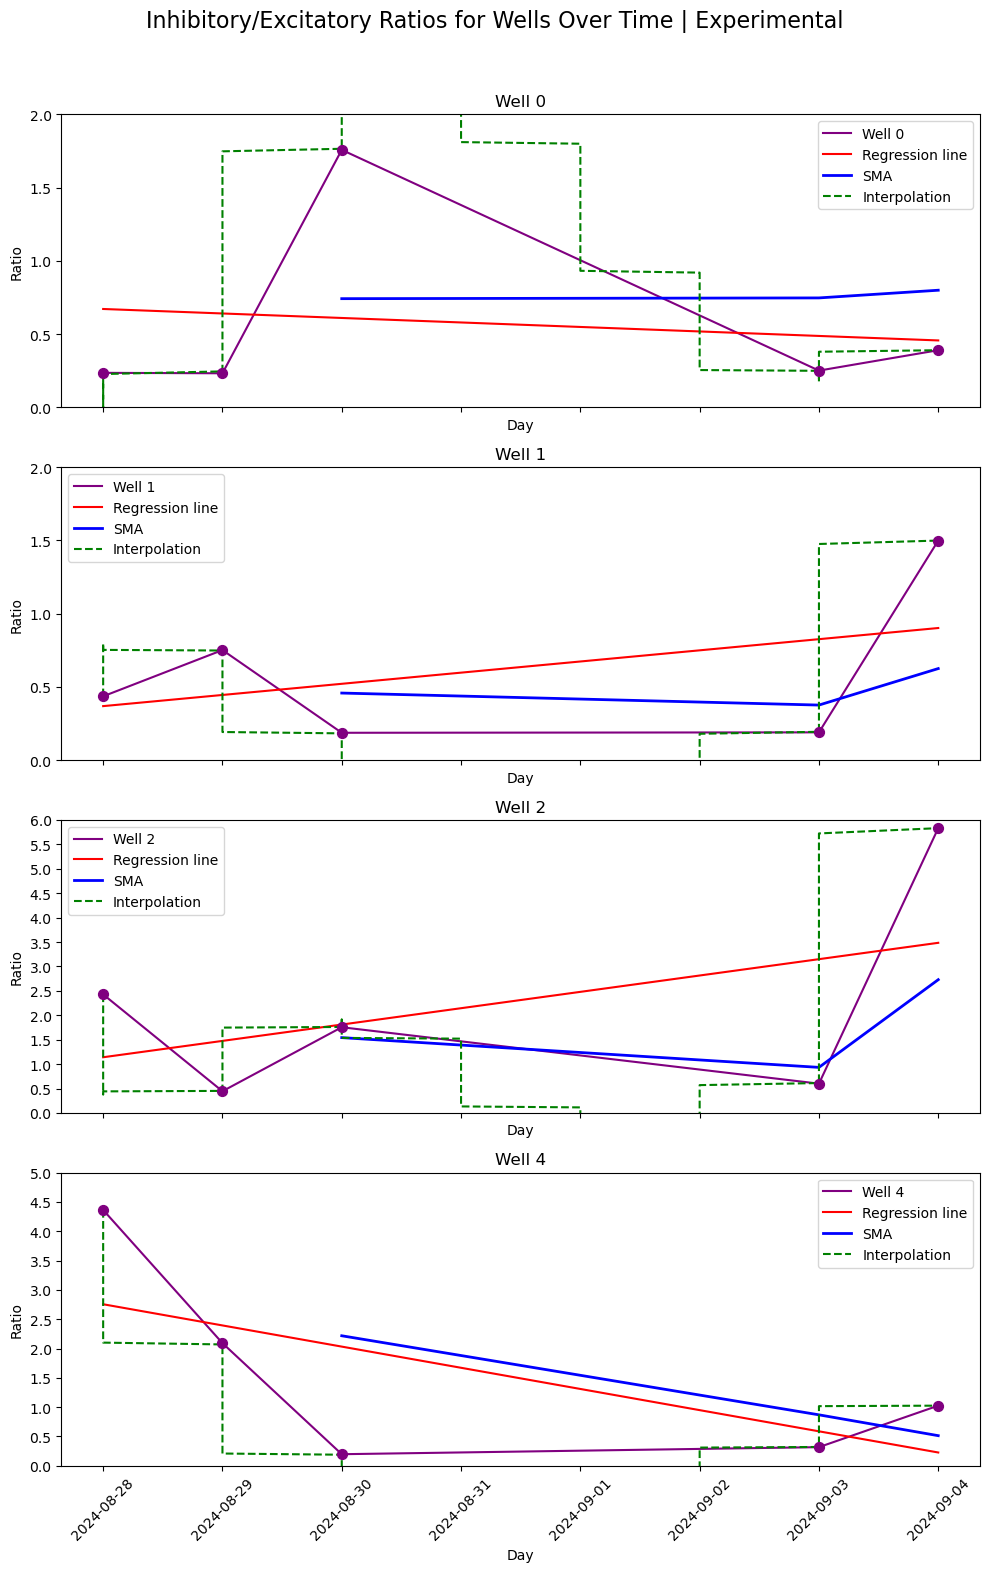

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy.interpolate import make_interp_spline

#
#           ****** FOR EXPERIMENTAL GROUP - CSV HEADER: Chip,day,daytrial,Well,Inhibitory Count,Excitatory Count,Ratio
#

def plot_data2(file_path):

    df = pd.read_csv(file_path)

    # Convert 'day' to datetime format
    df['day'] = pd.to_datetime(df['day'], format='%y%m%d')

    df = df.sort_values(by=['day', 'Well'])

    unique_wells = df['Well'].unique()

    fig, axes = plt.subplots(len(unique_wells), 1, figsize=(10, len(unique_wells) * 4), sharex=True)
    fig.suptitle(f'Inhibitory/Excitatory Ratios for Wells Over Time | Experimental', fontsize=16)

    for i, well in enumerate(unique_wells):
        ax = axes[i] if len(unique_wells) > 1 else axes
        group = df[df['Well'] == well].groupby('day').mean(numeric_only=True).reset_index()
        
        ax.plot(group['day'], group['Ratio'], linestyle='-', label=f'Well {well}', color='purple')
        ax.scatter(group['day'], group['Ratio'], color='purple', s=50, zorder=5)
        
        # Add regression line
        slope, intercept, r_value, p_value, std_err = linregress(group['day'].map(pd.Timestamp.toordinal), group['Ratio'])
        ax.plot(group['day'], intercept + slope * group['day'].map(pd.Timestamp.toordinal), 'r', label='Regression line')
        
        # Calculate and plot SMA
        sma = group['Ratio'].rolling(window=3).mean()
        ax.plot(group['day'], sma, color='blue', linewidth=2, label='SMA')
        
        # Add green interpolation line
        x_new = np.linspace(group['day'].map(pd.Timestamp.toordinal).min(), group['day'].map(pd.Timestamp.toordinal).max(), 500)
        spline = make_interp_spline(group['day'].map(pd.Timestamp.toordinal), group['Ratio'], k=3)
        y_smooth = spline(x_new)
        interp_dates = [pd.Timestamp.fromordinal(int(day)) for day in x_new]
        ax.plot(interp_dates, y_smooth, color='green', linestyle='--', label='Interpolation')
        
        ax.set_title(f'Well {well}')
        ax.set_xlabel('Day')
        ax.set_ylabel('Ratio')
        buffer = 0.1  # 10% buffer
        ax.set_ylim(group['Ratio'].min() - buffer, group['Ratio'].max() + buffer)
        ax.set_yticks(np.arange(np.floor(group['Ratio'].min()), np.ceil(group['Ratio'].max()) + 0.1, 0.5))
        ax.set_xticks(pd.date_range(group['day'].min(), group['day'].max(), freq='D'))
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.savefig(f'/Users/evankolberg/Desktop/HALnalysis_summer_2024_data/plots/freq_game_analysis/ratios_2.png', dpi=800)
    plt.show()

file_path = '/Users/evankolberg/Desktop/HALnalysis_summer_2024_data/plots/freq_game_analysis/chip_vis_data.csv'
plot_data2(file_path)